# **Модель расчета скоринга по заемщикам**

In [1]:
import warnings
warnings.filterwarnings('ignore')

## 1. Загрузка преобразованных данных

Сначала необходимо загрузить входные данные для реализации модели предсказаний. Извлекается вкладка "Модель" с преобразованными для модели данными.

In [2]:
import pandas as pd

xls = pd.ExcelFile('scoring.xlsx')
df = pd.read_excel(xls, 'Модель', header=None) # загрузка необходимой вкладки

# Преобразование DataFrame для удобства конвертации в числовые данные
df.columns = df.iloc[1]
df = df[2:]
df.reset_index(drop=True, inplace=True)
df.set_index('al_ContractNumber', inplace=True)
df.head()

1,al_amount,al_issue_M_group,psp_issue_rgn_group,sex,is_client_local,has_snils,zaim_cards,age,responsecode,has_foreign_currency_credits,...,res_payout_tot_delay30,res_payout_tot_delay45,res_payout_tot_delay60,res_payout_tot_delay90,fl_cnt,fl_cnt_during_3M,fl_cnt_during_12M,fl_requests_cnt_12M,is_test,Без МФ
al_ContractNumber,,,,,,,,,,,,,,,,,,,,,
882-001-17,3000,1,2,1,0,0,0,2,1,0,...,4590.4,4590.4,4590.4,4590.4,1,1,1,1,0,0.25511
1776-001-17,5000,1,1,1,0,1,0,2,1,0,...,6500,6500,6500,6500,1,1,1,1,0,0.214343
2234-001-17,5000,1,1,1,0,1,0,3,1,0,...,0,0,0,0,0,0,0,0,0,0.202411
2649-001-17,5000,1,4,2,1,1,0,3,0,0,...,8000,8000,8000,8000,2,1,2,3,0,0.820044
2320-001-17,3000,1,4,2,1,1,0,3,0,0,...,3960,3960,3960,3960,1,1,1,1,0,0.925201


## 2. Удаление столбцов вне анализа и проверка на репрезентативность

Оставлены только столбца, которые будут предсказательными признаками, целевое поле ("res_npl_15") и поле "is_test" для последующего разделения на обучающую и тестовую выборки.

In [3]:
cols = df.columns.tolist()
to_remove = cols[34:38] + cols[39:56] + cols[-1:]

df = df.loc[:, ~df.columns.isin(to_remove)]
df.columns

Index(['al_amount', 'al_issue_M_group', 'psp_issue_rgn_group', 'sex',
       'is_client_local', 'has_snils', 'zaim_cards', 'age', 'responsecode',
       'has_foreign_currency_credits', 'court_counts', 'official_count',
       'has_resold_credits', 'cred_line_state', 'potreb_tot',
       'potreb_active_tot_group', 'potreb_other_states_tot', 'pdl_tot',
       'pdl_closed_tot', 'pdl_active_to_total_group', 'pdl_delay5_cnt',
       'pdl_delay30_cnt', 'pdl_delay60_cnt', 'pdl_delay90_cnt',
       'pdl_delay_more_cnt', 'pdl_prolong_cnt', 'avg_payout_period_pdl',
       'avg_pdl_full_cost', 'avg_pdl_amount', 'pdl_delay5_avg',
       'pdl_delay30_avg', 'pdl_delay60_avg', 'pdl_delay90_avg',
       'pdl_delay_more_avg', 'res_npl_15', 'is_test'],
      dtype='object', name=1)

Также, проверим выборку на пропущенные значения, тип и выбросы.

In [4]:
df = df.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9983 entries, 882-001-17 to 84312-128-17
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   al_amount                     9983 non-null   int32
 1   al_issue_M_group              9983 non-null   int32
 2   psp_issue_rgn_group           9983 non-null   int32
 3   sex                           9983 non-null   int32
 4   is_client_local               9983 non-null   int32
 5   has_snils                     9983 non-null   int32
 6   zaim_cards                    9983 non-null   int32
 7   age                           9983 non-null   int32
 8   responsecode                  9983 non-null   int32
 9   has_foreign_currency_credits  9983 non-null   int32
 10  court_counts                  9983 non-null   int32
 11  official_count                9983 non-null   int32
 12  has_resold_credits            9983 non-null   int32
 13  cred_line_state      

In [5]:
df.describe()

1,al_amount,al_issue_M_group,psp_issue_rgn_group,sex,is_client_local,has_snils,zaim_cards,age,responsecode,has_foreign_currency_credits,...,avg_payout_period_pdl,avg_pdl_full_cost,avg_pdl_amount,pdl_delay5_avg,pdl_delay30_avg,pdl_delay60_avg,pdl_delay90_avg,pdl_delay_more_avg,res_npl_15,is_test
count,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000,...,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000,9983.000000
mean,4306.821597,1.660723,3.031153,1.274767,0.452970,0.165481,0.001703,2.153761,0.564960,0.001803,...,0.941501,1.039267,0.107583,0.007012,0.024341,0.009516,0.013924,0.011019,0.452469,0.299108
std,932.999154,0.860069,1.164634,0.446419,0.497808,0.371633,0.041233,0.790330,0.495787,0.042426,...,0.234697,0.194239,0.309868,0.083447,0.154114,0.097090,0.117180,0.104395,0.497761,0.457890
min,3000.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3000.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5000.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5000.000000,3.000000,4.000000,2.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,5000.000000,3.000000,4.000000,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,...,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Пропущенных значений нет, выбросов - нет. Всего имеется 34 предсказательных признака. Данные готовы для обучения.

## 3. Статистический анализ данных

Проверим поведение исследуемых данных для осознанного применения моделей МЛ, которые могут использовать предположение о нормальности входных данных.

Выдвинем гипотезу о том, что исходные данные подчиняются нормальному распределению.

In [6]:
#!pip install pingouin

In [7]:
from pingouin import multivariate_normality
import pandas as pd
import numpy as np

# perform the Henze-Zirkler Multivariate Normality Test
multivariate_normality(df.iloc[:, 0:-2], alpha=.05) # analysing without the last two columns

HZResults(hz=39932, pval=0.0, normal=False)

<function matplotlib.pyplot.show(close=None, block=None)>

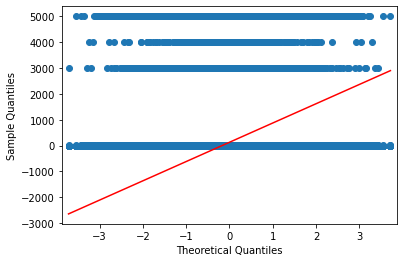

In [8]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot as plt

qqplot(df.iloc[:, 0:-2], line='s')
plt.show

Тест Хенза-Зиклира на многоразмерное нормальное распределение и QQ-график дает нам понять, что исходные данные не подчиняюся нормальному распределению (p-value -> 0.0). Гипотеза опровергнута. <br>
Значит, не следует использовать в качестве моделей обучения алгоритмы дискриминантного анализа (LDA, QDA). Остальные классические варианты претерпят данное поведеление, но точность может быть неабсолютной.

## 4. Разделение исходных данных на обучающую и тестовую выборки

Выборка разделяется для обучения и теста согласно полю "is_test".

In [9]:
train_df = df.loc[df['is_test'] == 0]
test_df = df.loc[df['is_test'] == 1]

X_train = train_df.iloc[:, 0:-2].to_numpy()
y_train = train_df.iloc[:, -2].to_numpy() # res_npl_15

X_test = test_df.iloc[:, 0:-2].to_numpy()
y_test = test_df.iloc[:, -2].to_numpy() # res_npl_15

## 5. Важность признаков

С помощью рандомного леса рассчитаем показатели важности предикторов через их влияние на примеси в узлах деревьев. Таким образом мы сможем отобрать те признаки данных, которые более ответственные за выборку в целом.

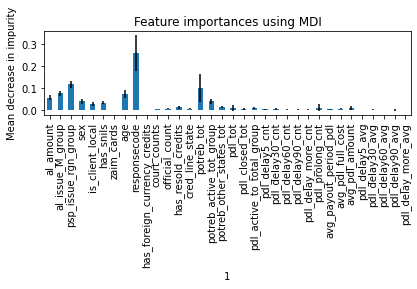

In [10]:
from sklearn.ensemble import RandomForestClassifier

feature_names = df.columns[:-2]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Также, найдем признаки, с которыми больше всего коррелирует целевая переменная (res_npl_15).

In [11]:
corr_matrix = df.corr()
corr_matrix['res_npl_15'].sort_values(ascending=False)

1
res_npl_15                      1.000000
psp_issue_rgn_group             0.210360
potreb_active_tot_group         0.142739
al_issue_M_group                0.104487
is_client_local                 0.090940
age                             0.085172
sex                             0.081095
avg_payout_period_pdl           0.069668
cred_line_state                 0.053860
pdl_active_to_total_group       0.009905
has_foreign_currency_credits    0.008802
zaim_cards                      0.001503
is_test                        -0.004428
pdl_delay5_avg                 -0.013682
has_snils                      -0.018673
court_counts                   -0.035594
pdl_delay5_cnt                 -0.037083
pdl_delay60_avg                -0.043500
official_count                 -0.044227
pdl_delay_more_avg             -0.063180
pdl_delay60_cnt                -0.066759
pdl_delay90_avg                -0.070236
pdl_delay30_avg                -0.076984
pdl_closed_tot                 -0.080302
pdl_delay_more

На основе диаграммы и показателей корреляции, было решено о дальнейшем использовании признаков №0-5, №7-8 и №14-15 (по порядку положительного направления OX на диаграмме).

In [12]:
picked_features = [0, 1, 2, 3, 4, 5, 7, 8, 14, 15] 

X_train = X_train[:, picked_features]
X_test = X_test[:, picked_features]

## 6. Создание моделей и обучение

Для начала над данными применяется стандартизация для более эффективного обучения модели.

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Исследуем нескольких моделей классификации и определим их наилучшие показатели используемой метрики (ROC AUC) после применения RandomizedSearchCV на кросс-валидации с k = 10. В конце применяем лучшие модели-предикторы на тестовой выборке и найденные значения ROC AUC конвертируем в коэффициент Gini (Gini = 2*AUC-1) для более удобного анализа скоринга.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import roc_auc_score

from scipy.stats import loguniform, uniform, randint
from sklearn.model_selection import RandomizedSearchCV

def gini_output(X_test, y_test, classifier):
    print('Best Gini score: ', 2 * classifier.best_score_ - 1) # Gini = 2*ROC_AUC - 1
    print('Hyperparameters: ', classifier.best_params_)

#### Logistic Regression

In [15]:
space = {"solver": ['newton-cg', 'lbfgs', 'liblinear'],
         "penalty" : ['none', 'l1', 'l2', 'elasticnet'],
         "C": loguniform(1e-5, 100)}

log_reg = LogisticRegression()
GS_1 = RandomizedSearchCV(log_reg, space, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=10, random_state=1)
GS_1.fit(X_train, y_train)

gini_output(X_test, y_test, GS_1)

Best Gini score:  0.5992132441067908
Hyperparameters:  {'C': 14.028057068813272, 'penalty': 'l2', 'solver': 'liblinear'}


#### Random Forest

In [16]:
space = {"max_depth": randint(3, 10),
         "n_estimators" : randint(100, 1000),
         "max_features": randint(1, 11),
         "min_samples_split": randint(1, 11),
         "min_samples_leaf": randint(1, 11),
         "bootstrap": [True, False],
         "criterion": ["gini", "entropy"]}
forest = RandomForestClassifier()
GS_2 = RandomizedSearchCV(forest, space, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=10, random_state=1)
GS_2.fit(X_train, y_train)

gini_output(X_test, y_test, GS_2)

Best Gini score:  0.611298104726318
Hyperparameters:  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 742}


#### Support Vector Machine

In [17]:
space = {"C": loguniform(1e-5, 100), "gamma": loguniform(0.01, 1)}
svm = SVC()
GS_3 = RandomizedSearchCV(svm, space, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=10, random_state=1)
GS_3.fit(X_train, y_train)

gini_output(X_test, y_test, GS_3)

Best Gini score:  0.5776216046280882
Hyperparameters:  {'C': 1.805498110203051, 'gamma': 0.04986509881045028}


#### Gradient Boosting

In [18]:
space = {"learning_rate": uniform(),
         "subsample"    : uniform(),
         "n_estimators" : randint(100, 1000),
         "max_depth"    : randint(4, 10)}
gboost = GradientBoostingClassifier()
GS_4 = RandomizedSearchCV(gboost, space, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=10, random_state=1)
GS_4.fit(X_train, y_train)

gini_output(X_test, y_test, GS_4)

Best Gini score:  0.5978495640897221
Hyperparameters:  {'learning_rate': 0.044551878544761725, 'max_depth': 4, 'n_estimators': 620, 'subsample': 0.2257093386078547}


#### XGBoost

In [20]:
!pip install xgboost

In [22]:
import xgboost as xgb

space = {"learning_rate": loguniform(0.01, 1),
         "min_child_weight": randint(1, 10),
         "gamma": loguniform(0.01, 1),
         "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
         "max_depth": randint(4, 10)}

xgb_cl = xgb.XGBClassifier()
GS_5 = RandomizedSearchCV(xgb_cl, space, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=10, random_state=1)
GS_5.fit(X_train, y_train)

gini_output(X_test, y_test, GS_5) 

Best Gini score:  0.6150968076596715
Hyperparameters:  {'colsample_bytree': 0.7, 'gamma': 0.08211256449180217, 'learning_rate': 0.07267702383040954, 'max_depth': 4, 'min_child_weight': 7}


После анализа эффективности моделей решено об использовании XGBoost как основной модели для дальнейшей работы с данными (помимо точности, выигрывает во времени).

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

model = GS_5.best_estimator_
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
#print(classification_report(y_test, y_pred, target_names=['Не выплатил (0)', 'Выплатил (1)']))
#print(confusion_matrix(y_test, y_pred))

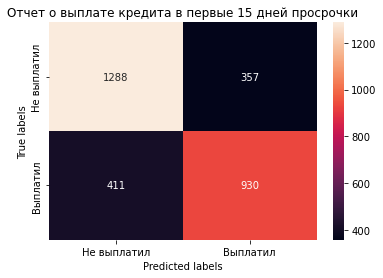

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Отчет о выплате кредита в первые 15 дней просрочки'); 
ax.xaxis.set_ticklabels(['Не выплатил', 'Выплатил']); ax.yaxis.set_ticklabels(['Не выплатил', 'Выплатил']);

## 7. Вывод вероятности оплаты кредита в первые 15 дней после просрочки

In [27]:
def npl_15_prob(loaner, model):
    probs = model.predict_proba(loaner.reshape(1, -1))
    return f'Вероятность оплаты кредита в первые 15 дней после просрочки: {round(probs[0][1], 2)}'

In [28]:
print(npl_15_prob(X_test[0], model)) # проверка на первом клиенте из тестовой выборки

Вероятность оплаты кредита в первые 15 дней после просрочки: 0.6800000071525574


На практике данные о клиенте будут извлекаться из базы данных по номеру его контракта ('al_ContractNumber').